1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

2. Loading and Understanding the Dataset

In [2]:
pip install kaggle

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:59<00:00, 18.7MB/s]
100% 5.20G/5.20G [03:59<00:00, 23.3MB/s]


In [4]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [5]:
import subprocess

# Buat folder baru
subprocess.run(["mkdir", "/content/skin-cancer-mnist-ham10000"])

# Pindahkan dua folder ke dalam folder baru
subprocess.run(["mv", "/content/HAM10000_images_part_1", "/content/skin-cancer-mnist-ham10000/"])
subprocess.run(["mv", "/content/HAM10000_images_part_2", "/content/skin-cancer-mnist-ham10000/"])

CompletedProcess(args=['mv', '/content/HAM10000_images_part_2', '/content/skin-cancer-mnist-ham10000/'], returncode=0)

In [6]:
# Setting data directory
data_directory = os.path.join("/content/")
os.listdir(data_directory)# Loading HAM10000_meatdata.csv
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

3. Creating a Dictionary for Image Path and Lesion Type

In [7]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((150,150))));
data.sample(5)

lesion_id      image_id   dx    dx_type   age     sex  \
9041  HAM_0001190  ISIC_0028873   nv      histo  70.0  female   
9672  HAM_0002554  ISIC_0028585   nv  consensus  30.0    male   
888   HAM_0000106  ISIC_0024770  bkl  consensus  50.0    male   
4180  HAM_0000885  ISIC_0025293   nv  follow_up  40.0  female   
8296  HAM_0001525  ISIC_0025662   nv      histo  35.0    male   

         localization                            cell_type  \
9041  upper extremity                Melanocytic nevi (nv)   
9672             back                Melanocytic nevi (nv)   
888              face  Benign keratosis-like lesions (bkl)   
4180  upper extremity                Melanocytic nevi (nv)   
8296  upper extremity                Melanocytic nevi (nv)   

                                                  path  \
9041  /content/ham10000_images_part_1/ISIC_0028873.jpg   
9672  /content/ham10000_images_part_1/ISIC_0028585.jpg   
888   /content/ham10000_images_part_1/ISIC_0024770.jpg   
4180  /content/ham10000_images_part_1/ISIC_0025293.jpg   
8296  /content/ham10000_images_part_1/ISIC_0025662.jpg   

                                            image_pixel  
9041  [[[100, 69, 74], [103, 72, 77], [110, 80, 84],...  
9672  [[[153, 138, 138], [154, 139, 139], [155, 140,...  
888   [[[28, 15, 16], [27, 13, 14], [26, 13, 15], [2...  
4180  [[[221, 146, 158], [219, 144, 153], [225, 146,...  
8296  [[[207, 155, 153], [209, 157, 157], [210, 159,...

4. Exploratory Data Analysis (EDA)

In [8]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

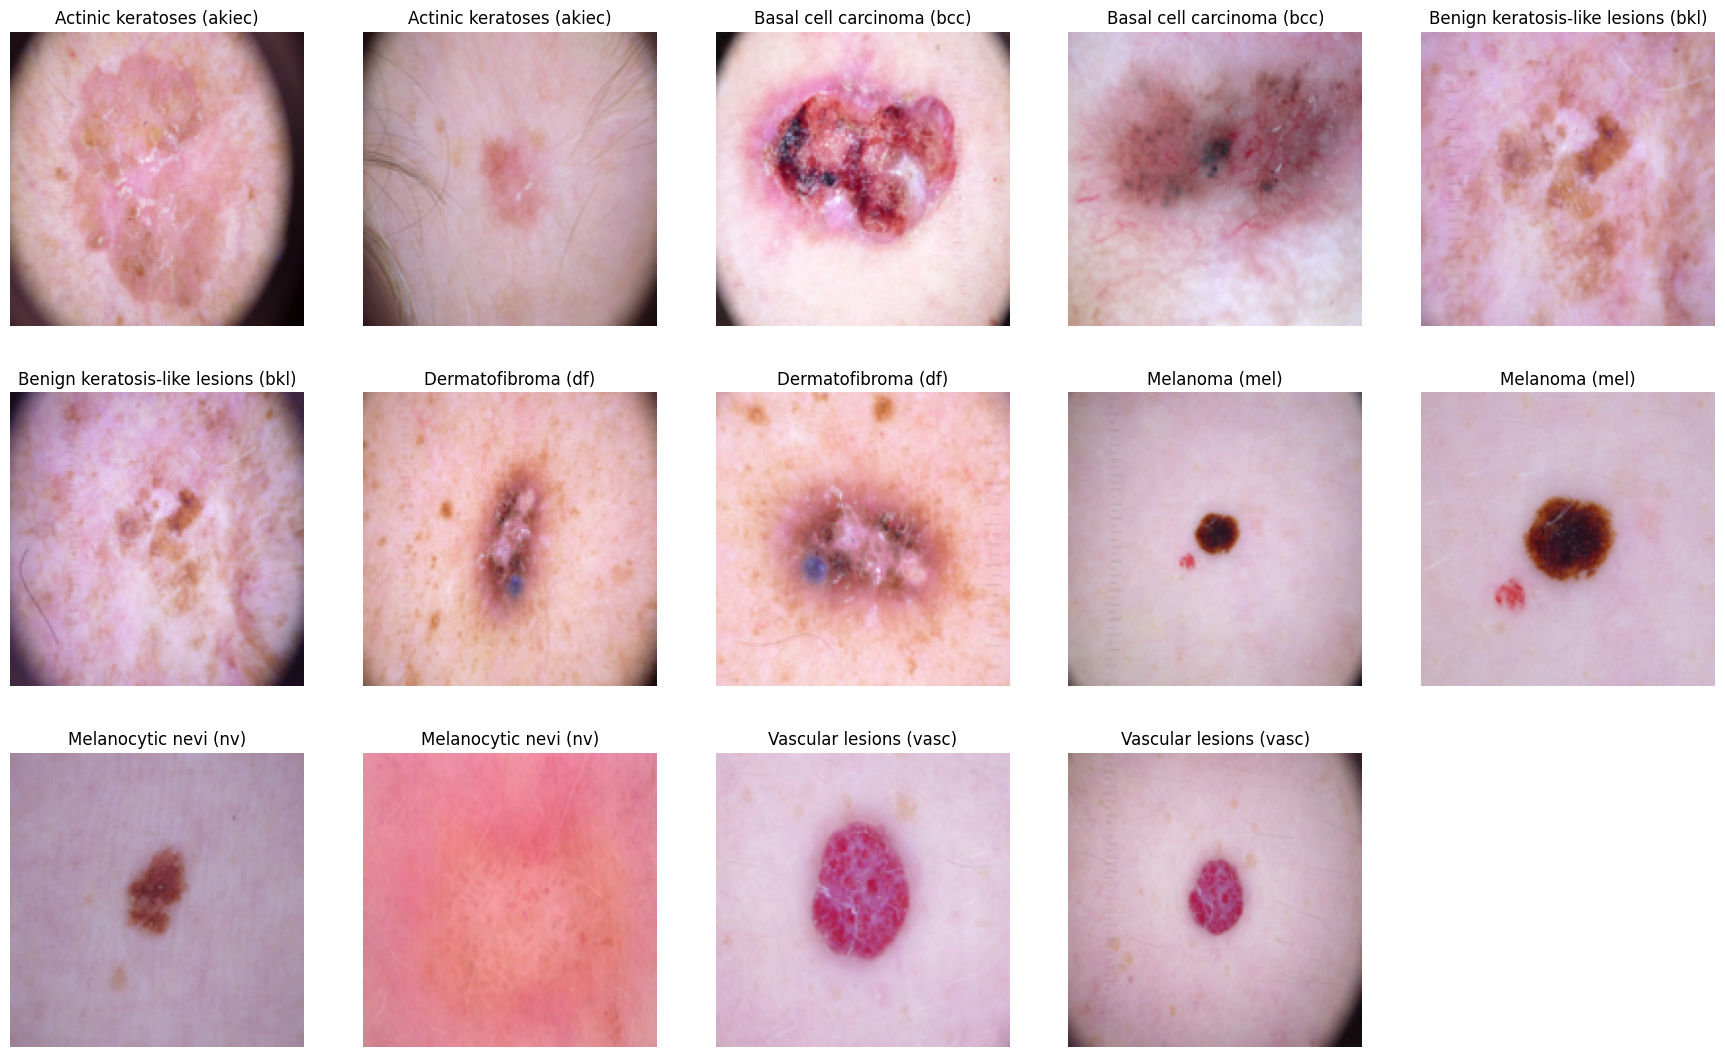

In [9]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

5. Prepocessing

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [11]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [12]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')# Categorically encoding label of the images
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

lesion_id      image_id   dx    dx_type  age     sex localization  \
6040  HAM_0002288  ISIC_0027803   nv  follow_up   70    male      abdomen   
8668  HAM_0006398  ISIC_0027568   nv      histo   70    male          ear   
684   HAM_0002809  ISIC_0026139  bkl      histo   45  female         face   
4049  HAM_0000471  ISIC_0031656   nv  follow_up   50    male        trunk   
9006  HAM_0000707  ISIC_0024561   nv      histo   70  female      abdomen   

                                cell_type  \
6040                Melanocytic nevi (nv)   
8668                Melanocytic nevi (nv)   
684   Benign keratosis-like lesions (bkl)   
4049                Melanocytic nevi (nv)   
9006                Melanocytic nevi (nv)   

                                                  path  \
6040  /content/ham10000_images_part_1/ISIC_0027803.jpg   
8668  /content/ham10000_images_part_1/ISIC_0027568.jpg   
684   /content/ham10000_images_part_1/ISIC_0026139.jpg   
4049  /content/ham10000_images_part_2/ISIC_0031656.jpg   
9006  /content/ham10000_images_part_1/ISIC_0024561.jpg   

                                            image_pixel  label  
6040  [[[228, 149, 148], [228, 148, 146], [228, 149,...      0  
8668  [[[180, 151, 135], [193, 160, 141], [191, 157,...      0  
684   [[[114, 94, 93], [114, 94, 93], [113, 92, 88],...      2  
4049  [[[227, 139, 150], [228, 140, 151], [224, 135,...      0  
9006  [[[190, 168, 163], [192, 173, 167], [194, 175,...      0

6. Data Augmentation

In [13]:
# Sorting data by label and resetting index
data = data.sort_values('label')
data = data.reset_index(drop=True)

# Getting indices for each label
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

# Creating DataFrames based on indices
df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

# Replicating rows in DataFrames
df_index1 = pd.concat([df_index1] * 4, ignore_index=True)
df_index2 = pd.concat([df_index2] * 4, ignore_index=True)
df_index3 = pd.concat([df_index3] * 11, ignore_index=True)
df_index4 = pd.concat([df_index4] * 17, ignore_index=True)
df_index5 = pd.concat([df_index5] * 45, ignore_index=True)
df_index6 = pd.concat([df_index6] * 52, ignore_index=True)

# Concatenating all DataFrames
frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

# Visualizing data distribution
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [14]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(42446, 150, 150, 3)
(42446, 1)


In [15]:
# Mencetak jumlah persebaran data untuk setiap kelas skin type sebelum augmentasi dengan label deskriptif
skin_type_counts_before = data['dx'].value_counts()
skin_type_counts_before.index = skin_type_counts_before.index.map(lesion_type_dict.get)

print("Persebaran data untuk setiap kelas skin type sebelum augmentasi:")
print(skin_type_counts_before)

# Mencetak jumlah persebaran data untuk setiap kelas skin type setelah augmentasi dengan label deskriptif
skin_type_counts = final_data['dx'].value_counts()
skin_type_counts.index = skin_type_counts.index.map(lesion_type_dict.get)

print("Persebaran data untuk setiap kelas skin type setelah augmentasi:")
print(skin_type_counts)


Persebaran data untuk setiap kelas skin type sebelum augmentasi:
dx
Melanocytic nevi (nv)                  6705
Melanoma (mel)                         1113
Benign keratosis-like lesions (bkl)    1099
Basal cell carcinoma (bcc)              514
Actinic keratoses (akiec)               327
Vascular lesions (vasc)                 142
Dermatofibroma (df)                     115
Name: count, dtype: int64
Persebaran data untuk setiap kelas skin type setelah augmentasi:
dx
Melanocytic nevi (nv)                  6705
Vascular lesions (vasc)                6532
Basal cell carcinoma (bcc)             6168
Dermatofibroma (df)                    6095
Actinic keratoses (akiec)              5886
Melanoma (mel)                         5565
Benign keratosis-like lesions (bkl)    5495
Name: count, dtype: int64


7. Model Creation, Training, and Testing

In [22]:

import time

def prepare_for_train_test(X, Y):
    start_time = time.time()
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(X_test)

    end_time = time.time()
    print("prepare_for_train_test execution time:", end_time - start_time, "seconds")

    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

def calculate_variance(X_train, Y_train, label):
    class_indices = np.where(Y_train == label)[0]
    class_data = [X_train[i] for i in class_indices]
    variances = [np.var(img) for img in class_data]
    return variances

In [23]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
model2 = create_model()

prepare_for_train_test execution time: 8.567141056060791 seconds
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        18496     
                                                         

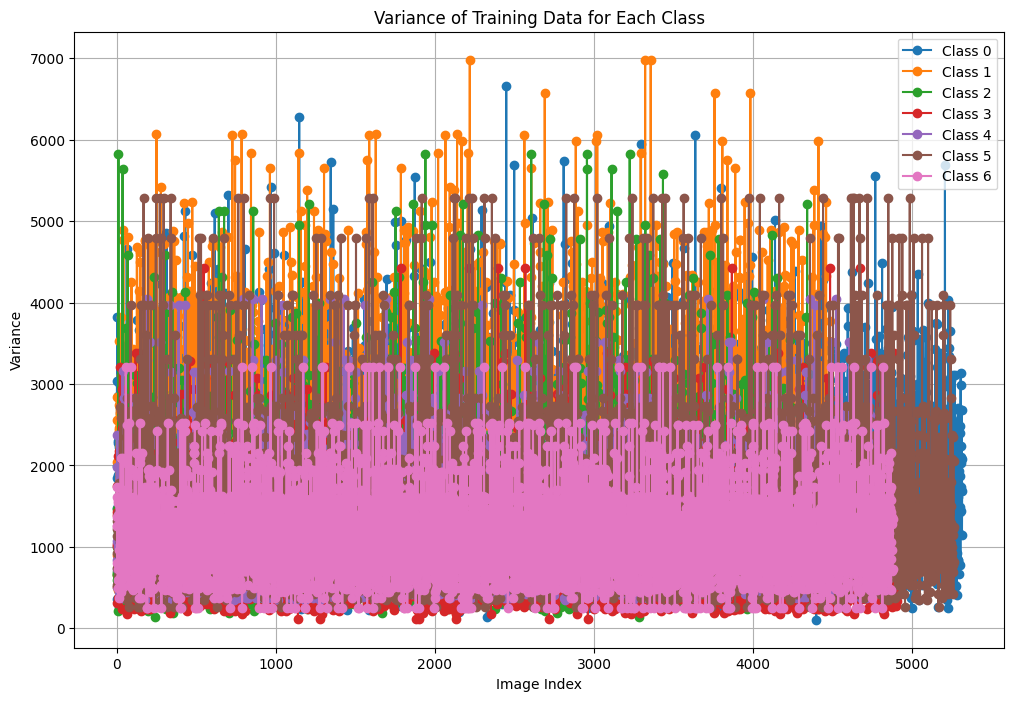

In [24]:

variance_dict = {label: calculate_variance(X_train_aug, Y_train_aug, label) for label in np.unique(Y_train_aug)}

import matplotlib.pyplot as plt

# Plot untuk variansi setiap kelas
plt.figure(figsize=(12, 8))

for label, variances in variance_dict.items():
    plt.plot(np.arange(len(variances)), variances, marker='o', label=f'Class {label}')

plt.xlabel('Image Index')
plt.ylabel('Variance')
plt.title('Variance of Training Data for Each Class')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

Epoch 1/50
425/425 [==============================] - 7s 12ms/step - loss: 1.8521 - accuracy: 0.4597 - val_loss: 0.9723 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 2/50
425/425 [==============================] - 4s 9ms/step - loss: 0.7282 - accuracy: 0.7294 - val_loss: 0.5326 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 3/50
425/425 [==============================] - 4s 9ms/step - loss: 0.4303 - accuracy: 0.8407 - val_loss: 0.4028 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 4/50
425/425 [==============================] - 4s 9ms/step - loss: 0.3071 - accuracy: 0.8839 - val_loss: 0.3084 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 5/50
425/425 [==============================] - 4s 9ms/step - loss: 0.2347 - accuracy: 0.9118 - val_loss: 0.2668 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 6/50
425/425 [==============================] - 4s 9ms/step - loss: 0.1735 - accuracy: 0.9376 - val_loss: 0.2418 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 7/50
425/425 [==============================] - 4s 9ms/step - l

8. Evaluation and Testing of Models

Test Accuracy: 97.173%
266/266 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

          nv       0.99      0.84      0.91      1391
         mel       0.92      0.98      0.95      1080
         bkl       0.93      1.00      0.96      1141
         bcc       0.98      1.00      0.99      1238
       akiec       1.00      1.00      1.00      1153
        vasc       1.00      1.00      1.00      1270
          df       1.00      1.00      1.00      1217

    accuracy                           0.97      8490
   macro avg       0.97      0.97      0.97      8490
weighted avg       0.97      0.97      0.97      8490



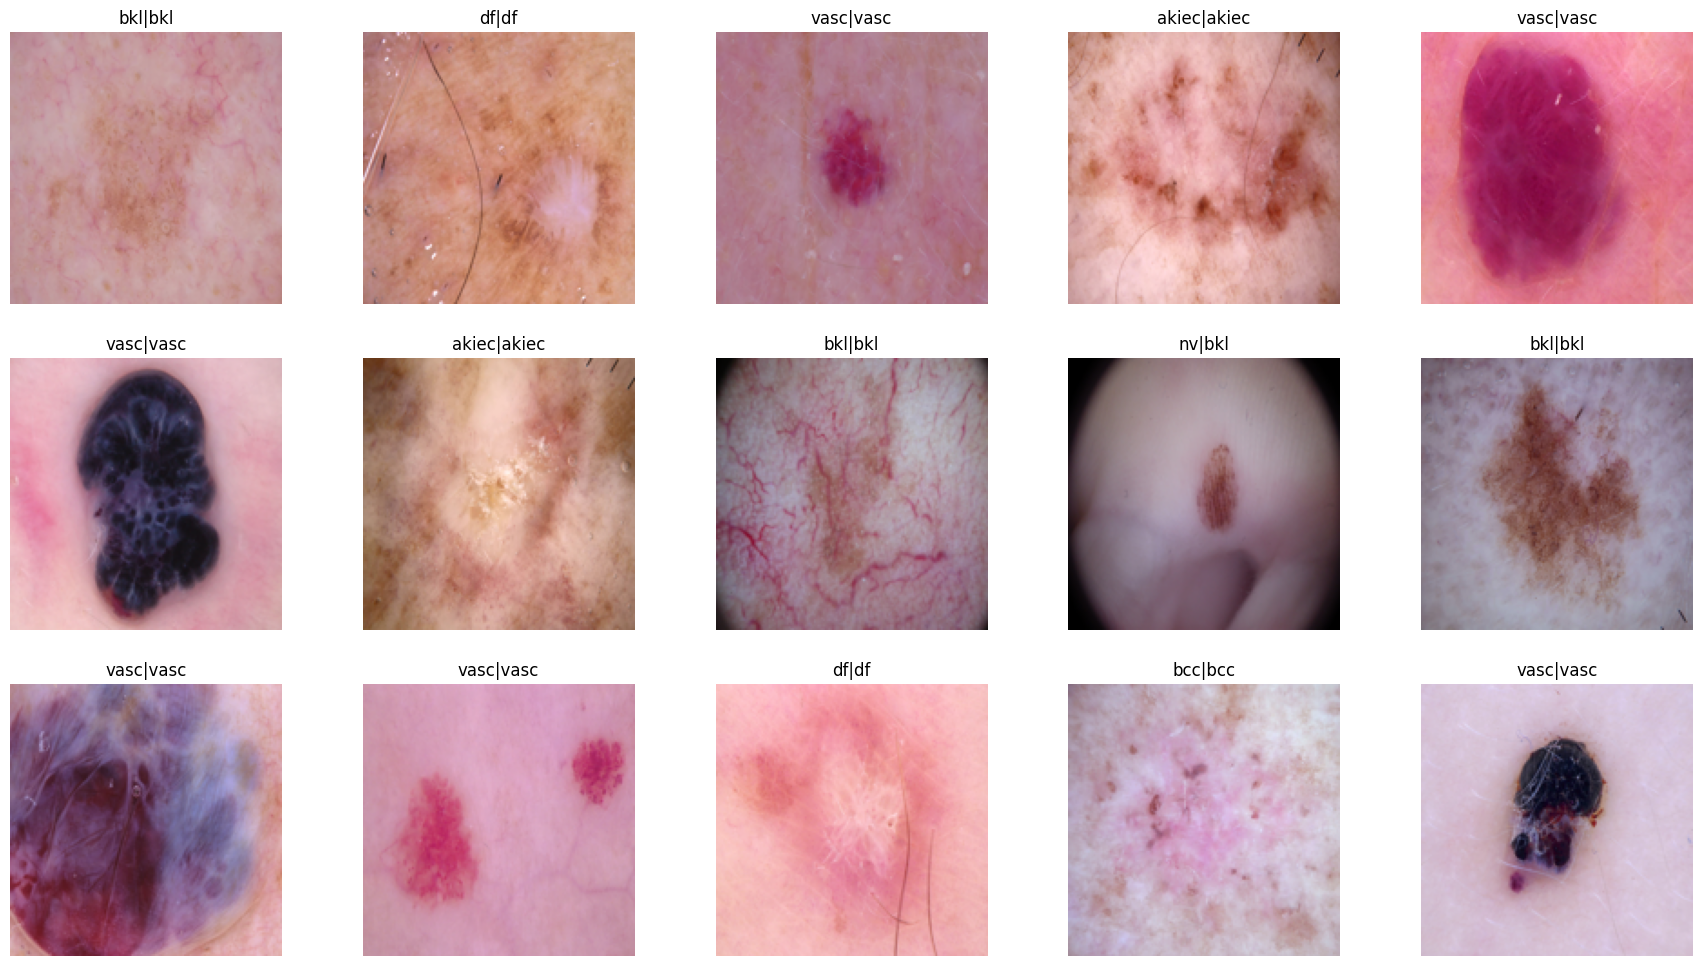

In [ ]:

#For Augmented Dataset:
test_model(model2, X_test_aug, Y_test_aug)

9. Plotting Model Training Curve and Testing

In [ ]:
#For Augmented Dataset:

plot_model_training_curve(model2_history)

266/266 [==============================] - 1s 2ms/step


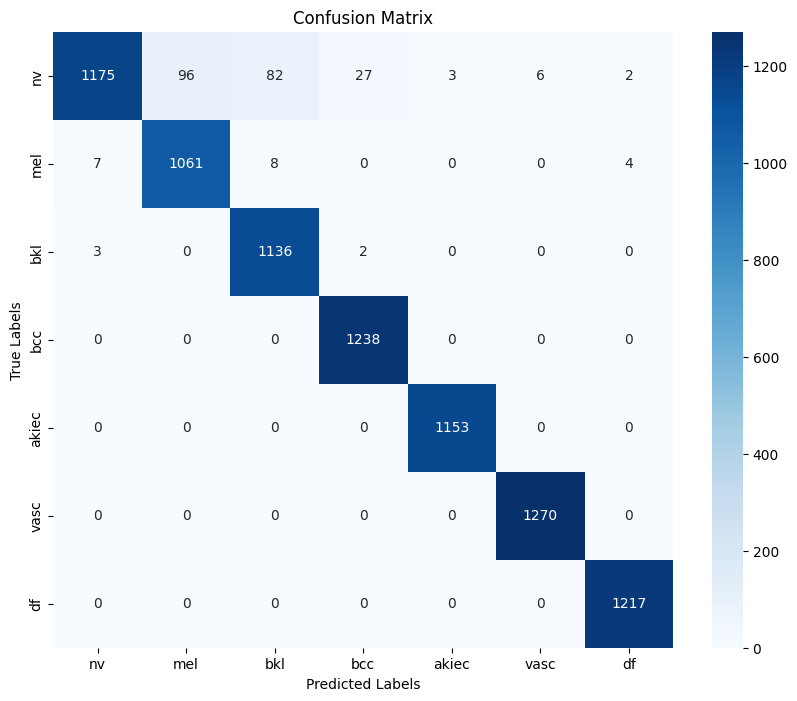

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Melakukan prediksi terhadap data uji
y_pred_aug = model2.predict(X_test_aug)
y_pred_aug = np.argmax(y_pred_aug, axis=1)

# Membuat confusion matrix
cm = confusion_matrix(Y_test_aug, y_pred_aug)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#10. New Data Preditiction

In [ ]:
from keras.preprocessing import image
from google.colab import files
#10. New Data Prediction
def predict_new_image(model):
    # Upload new image
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load and preprocess the image
        path = fn
        img = image.load_img(path, target_size=(50, 50))
        imgplot = plt.imshow(img)
        plt.title("Uploaded Image")
        plt.axis("off")
        plt.show()

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalize the image as the training data was normalized

        # Predict the class
        pred = model.predict(x)
        predicted_class = np.argmax(pred, axis=1)

        # Map the predicted label to the lesion type
        lesion_type = label_mapping[predicted_class[0]]
        lesion_name = lesion_type_dict[lesion_type]

        print(f"Predicted class: {lesion_name}")

# Call the function to predict new image
predict_new_image(model2)